<a href="https://colab.research.google.com/github/MatiasCovarrubias/jaxecon/blob/main/jaxDEQN_rbc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEQN Solver in Jax: Prelims

This notebook trains a neural net to output the optimal policy of a nonlinear Rbc model.



In [ ]:
# BACKEND RELATED: the default backend is CPU (change in Edit -> Notebook settings)
GPU = True # set True if using GPU (only to see GPU)
if GPU:
  !nvidia-smi

# precision
from jax import numpy as jnp, lax, random, config
double_precision = True
if double_precision:
  config.update("jax_enable_x64", True)
  precision = jnp.float64
else:
  precision = jnp.float32

# Imports
import matplotlib.pyplot as plt, jax, flax, optax, os, json
import flax.linen as nn
from flax.training.train_state import TrainState  # Useful dataclass to keep train state
from flax.training import checkpoints
from flax.core import freeze, unfreeze
import optax
from time import time
from typing import Sequence
config.update("jax_debug_nans", True)

# Mount Google Drive to store results (a pop up will appear, follow instructions)
from google.colab import drive
drive.mount('/content/drive')


Wed Feb 21 16:11:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Neural Net Policy

First, we use Flax to create the Neural Net, Notice that we activate the last layer using Softplus to guarantee that we get possitive outputs.

See https://flax.readthedocs.io/en/latest/getting_started.html

In [ ]:
class NeuralNet(nn.Module):
  features: Sequence[int]
  param_dtype = precision

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat, param_dtype=precision)(x))
    x = nn.softplus(nn.Dense(self.features[-1], param_dtype=precision)(x))
    return x

# Create Economic Model

We will represent our model as clas with four main methods (or functions): initial_obs to get first observation; step to advance a period, expectation to get the expectation term given a state, policy, and shock; and a loss funciton that gets as the loss given a state, policy and expectation term.

In [ ]:
class Model():
  """A JAX implementation of an RBC model."""

  def __init__(self):
    # set parameters
    self.beta = jnp.array(0.96, dtype=precision)
    self.alpha = jnp.array(0.3, dtype=precision)
    self.delta = jnp.array(0.1, dtype=precision)
    self.rho = jnp.array(0.9, dtype=precision)
    self.shock_sd = jnp.array(0.02, dtype=precision)


    # set steady state and standard deviations for normalization
    self.k_ss = jnp.log((self.alpha/(1/self.beta-1+self.delta))**(1/(1-self.alpha)))
    self.a_ss = jnp.array(0, dtype=precision)
    self.obs_ss = jnp.array([self.k_ss, 0], dtype=precision)
    self.obs_sd = jnp.array([1, 1], dtype=precision)  # use 1 if you don't have an estimate
    self.policy_ss = self.k_ss

    # number of policies
    self.n_actions = 1

  def initial_obs(self, rng):
    """ Get initial obs given first shock """
    rng_k, rng_a = random.split(rng,2)
    K = random.uniform(
            rng_k, minval=0.9 * jnp.exp(self.k_ss), maxval=1.1 * jnp.exp(self.k_ss), dtype=precision
        )  # get uniform draw around the steady state
    A = random.uniform(
            rng_a, minval=0.9 * jnp.exp(self.a_ss), maxval=1.1 * jnp.exp(self.a_ss), dtype=precision
        )  # get uniform draw around the steady state

    obs_init_notnorm = jnp.array([jnp.log(K), jnp.log(A)], dtype=precision)
    obs_init = (obs_init_notnorm-self.obs_ss)/self.obs_sd # normalize
    return obs_init

  def step(self, obs, policy, shock):
    """ A period step of the model, given current obs, the shock and policy """

    obs_notnorm = obs*self.obs_sd + self.obs_ss # denormalize
    K = jnp.exp(obs_notnorm[0])                 # Kt in levels
    a = obs_notnorm[1]                    # a_{t}
    a_tplus1 = self.rho * a + self.shock_sd*shock[0]   # recover a_{t+1}
    policy_notnorm = policy*jnp.exp(self.policy_ss)             # multiply by stst pols in level
    # K_tplus1 = (1-self.delta)*K + policy_notnorm[0]             #get K_{t+1}
    K_tplus1 = policy_notnorm[0]             #get K_{t+1}
    obs_next_notnorm = jnp.array([jnp.log(K_tplus1),a_tplus1])  #concatenate observation
    obs_next = (obs_next_notnorm-self.obs_ss)/self.obs_sd        # normalize

    return obs_next


  def expect_realization(self, obs_next, policy_next):
    """ A realization (given a shock) of the expectation terms in system of equation """

    policy_notnorm = policy_next*jnp.exp(self.policy_ss) # multiply by stst pols in levels
    K_tplus1 = policy_notnorm[0]                                # define investment

    # Process observation
    obs_notnorm = obs_next*self.obs_sd + self.obs_ss     # denormalize obs
    K = jnp.exp(obs_notnorm[0])                          # K_{t+1} in levels
    a = obs_notnorm[1]                             # a_{t}
    I = K_tplus1 - (1-self.delta)*K
    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I

    # Calculate the FOC for Pk
    expect_realization = (1/C) * (1+ A * self.alpha * K**(self.alpha-1)-self.delta)

    return expect_realization

  def loss(self, obs, expect, policy):
    """ Calculate loss associated with observing obs, having policy_params, and expectation exp """

    policy_notnorm = policy*jnp.exp(self.policy_ss)
    K_tplus1 = policy_notnorm[0]

    # Process observation
    obs_notnorm = obs*self.obs_sd + self.obs_ss        # denormalize
    K = jnp.exp(obs_notnorm[0])                        # put in levels
    a = obs_notnorm[1]

    # Rest of variables
    I = K_tplus1-(1-self.delta)*K
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I

    # Calculate the FOC for Pk
    FOC_loss = (1/C)/(self.beta*expect) - 1
    mean_loss = jnp.mean(jnp.array([FOC_loss**2])) # here there is just one, but more gemore generally.
    mean_accuracy = jnp.mean(jnp.array([1-jnp.abs(FOC_loss)]))
    min_accuracy = jnp.min(jnp.array([1-jnp.abs(FOC_loss)]))
    return mean_loss, mean_accuracy, min_accuracy

  def sample_shock(self, rng, n_draws=1):
    """ sample one realization of the shock.
    Uncomment second line for continuous shocks instead of grid """
    # return random.choice(rng, jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816]))
    return random.normal(rng, shape=(n_draws,), dtype=precision)

  def mc_shocks(self, rng=random.PRNGKey(0), mc_draws=8):
    """ sample omc_draws realizations of the shock (for monte-carlo)
    Uncomment second line for continuous shocks instead of grid """
    # return  jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816])
    return random.normal(rng, shape=(mc_draws,1), dtype = precision)

  def ir_shocks(self):
    """ (Optional) Define a set of shocks sequences that are of interest"""
    # ir_shock_1 = jnp.array([-1]+[0 for i in range(40)])
    # ir_shock_2 = jnp.array([1]+[0 for i in range(40)])
    ir_shock_1 = jnp.zeros(shape=(40,1), dtype = precision).at[0,:].set(-1)
    ir_shock_2 = jnp.zeros(shape=(40,1), dtype = precision).at[0,:].set(1)

    return jnp.array([ir_shock_1, ir_shock_2])

  def get_econ_stats(self, obs, policy):

    policy_notnorm = policy*jnp.exp(self.policy_ss)
    I = policy_notnorm[0]

    # Process observation
    obs_notnorm = obs*self.obs_sd + self.obs_ss        # denormalize
    K = jnp.exp(obs_notnorm[0])                        # put in levels
    a = obs_notnorm[1]

    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I

    return jnp.array([K,I,Y,C])

## Test the environment
We are going to make sure that the functions in our model are correct

In [ ]:
env = Model()
rng_test = random.PRNGKey(2)

# test steady state policies with random params
obs_ss = jnp.zeros_like(env.obs_ss, dtype=precision)
nn_test = NeuralNet([2,2] + [env.n_actions])
nn_policy_test = nn_test.apply
params_test = nn_test.init(rng_test, obs_ss) # we initialize random params
policy_ss = nn_policy_test(params_test,obs_ss)

# intialize env
obs_init = env.initial_obs(rng_test)

# apply a step
policy_firststep = nn_policy_test(params_test,obs_init)
shock_firststep = env.sample_shock(rng_test)
next_obs_firststep = env.step(obs_init, policy_firststep, shock_firststep)

# calculate loss in first step.

#First, we calculate expectations
mc_shocks = env.mc_shocks(rng_test)
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_init, policy_firststep, mc_shocks) # next obs given policy and for each shock in mc_shocks

mc_nextpols = nn_policy_test(params_test, mc_nextobs)
expect_firststep = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))

# Second, we calculate loss given expectations and policy
mean_loss, mean_accuracy, min_accuracy = env.loss(obs_init, expect_firststep, policy_firststep)
print("test first step: \n",
      ", Mean_loss:", mean_loss,
      ", Mean_accuracy:", mean_accuracy,
      ", Min_accuracy:", min_accuracy)

# calculate loss with policy = 1
policy_ones = jnp.ones_like(policy_firststep)
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_ss, policy_ones, jnp.zeros_like(mc_shocks)) # next obs given policy and for each shock in mc_shocks
print("next obs for montecarlo with policies =1 (should be an array with multiple obs =0)", mc_nextobs)

mc_nextpols = jnp.ones_like(mc_nextpols)
expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
print("expectation", expect)

mean_loss, mean_accuracy, min_accuracy = env.loss(obs_ss, expect, policy_ones)
print("test that StSt. policies give 0 loss in StSt. obs: \n",
      ", Mean_loss:", mean_loss,
      ", Mean_accuracy:", mean_accuracy,
      ", Min_accuracy:", min_accuracy)


test first step: 
 , Mean_loss: 0.08757804310517178 , Mean_accuracy: 0.7040641233220079 , Min_accuracy: 0.7040641233220079
next obs for montecarlo with policies =1 (should be an array with multiple obs =0) [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
expectation 0.958123199223544
test that StSt. policies give 0 loss in StSt. obs: 
 , Mean_loss: 0.0 , Mean_accuracy: 1.0 , Min_accuracy: 1.0


# Create Simulation function

In [ ]:
def create_episode_simul_fn(env, config):

  def sample_epis_obs(train_state, epis_rng):
    "sample obs of an episode"
    init_obs = env.initial_obs(epis_rng)
    period_rngs = random.split(epis_rng, config["periods_per_epis"])
    def period_step(env_obs, period_rng):
      policy = train_state.apply_fn(train_state.params, env_obs)                 # calculate policy
      period_shock = config["simul_vol_scale"]*env.sample_shock(period_rng)         # Sample next obs
      obs_next = env.step(env_obs, policy, period_shock)  # apply period steps.
      return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop
    _, epis_obs = lax.scan(period_step, init_obs, jnp.stack(period_rngs)) # we get the obs_batch
    # init_obs = init_obs.reshape(1,init_obs.shape[0])
    # epis_obs =jnp.concatenate([init_obs,epis_obs])
    return epis_obs

  return sample_epis_obs

## Test simulation function

In [ ]:
#CREATE ENV,  TRAIN_STATE AND RNG
env_test = Model()
nn_test = NeuralNet([2,2] + [env_test.n_actions])
rng_test = random.PRNGKey(1)

# CREATE CONFIG
config_test = {
    "periods_per_epis": 4,      # periods per episode
    "simul_vol_scale": 1,        # scale of volatility while simul
}

# GET FUNCTIONS
episode_simul_fn = create_episode_simul_fn(env_test, config_test)
train_state_test = TrainState.create(apply_fn=nn_test.apply, params=nn_test.init(rng_test, env_test.initial_obs(rng_test)), tx=optax.adam(0.05))
epis_rng, loss_rng = random.split(rng_test, 2)
epis_obs = episode_simul_fn(train_state_test, epis_rng)
print(epis_obs)

[[-0.3655886   0.03784751]
 [-0.33945239  0.02578569]
 [-0.34034204  0.00378591]
 [-0.33782834 -0.0035688 ]]


# Create Loss function

In [ ]:
def create_batch_loss_fn(env, config):

  def batch_loss_fn(params, train_state, batch_obs, loss_rng):
    """Loss function of a batch of obs."""
    period_mc_rngs = random.split(loss_rng, batch_obs.shape[0])
    batch_policies = train_state.apply_fn(params, batch_obs) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """Loss function for an individual period."""
      mc_shocks = env.mc_shocks(period_mc_rng, config["mc_draws"])
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = train_state.apply_fn(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      mean_loss, mean_accuracy, min_accuracy = env.loss(obs, expect, policy) # calculate loss
      return mean_loss, mean_accuracy, min_accuracy

    # parallelize callculation of period_loss for the entire batch
    mean_losses, mean_accuracies, min_accuracies = jax.vmap(period_loss)(batch_obs, batch_policies, jnp.stack(period_mc_rngs))
    mean_loss = jnp.mean(mean_losses)                   # average accross periods
    mean_accuracy = jnp.mean(mean_accuracies)           # average accross periods
    min_accuracy = jnp.min(min_accuracies)              # min accross periods and across eqs within period
    metrics = jnp.array([mean_loss, mean_accuracy, min_accuracy]) # pass as auxiliary info
    # metrics = jnp.array([mean_losses, mean_accuracies, min_accuracies]) # pass as auxiliary info
    return mean_loss, metrics

  return batch_loss_fn

## Test loss fn

We calculate the loss and metrics of a single epsiode. To do so, we set batch_size equal to periods_per_epis

In [ ]:
#CREATE ENV,  TRAIN_STATE AND RNG
env_test = Model()
nn_test = NeuralNet([2,2] + [env_test.n_actions])
rng_test = random.PRNGKey(1)

# CREATE CONFIG
config_test = {
    "periods_per_epis": 8,      # periods per episode
    "simul_vol_scale": 1,        # scale of volatility while simul
    "mc_draws": 32,             # only applies if shock is continuous
}
config_test["batch_size"] = config_test["periods_per_epis"]

# GET FUNCTIONS
episode_simul_fn = create_episode_simul_fn(env_test, config_test)
episode_loss_fn = create_batch_loss_fn(env_test, config_test)

train_state_test = TrainState.create(apply_fn=nn_test.apply, params=nn_test.init(rng_test, env_test.initial_obs(rng_test)), tx=optax.adam(0.05))
epis_rng, loss_rng = random.split(rng_test, 2)
epis_obs = episode_simul_fn(train_state_test, epis_rng)

loss, epis_metrics = episode_loss_fn(train_state_test.params, train_state_test, epis_obs, loss_rng)
print("loss:", loss)
print("epis_metrics:", epis_metrics)

loss: 0.0011850035778332838
epis_metrics: [0.001185   0.96803212 0.94555273]


# Create Epoch Training function



In [ ]:
def get_epoch_train_fn(env, config):
  episode_simul_fn = create_episode_simul_fn(env, config)
  episode_loss_fn = create_batch_loss_fn(env, config)

  def batch_train_fn(train_state, batch_obs, loss_rng):
    grad_fn = jax.value_and_grad(episode_loss_fn, has_aux=True)
    (_, epis_metrics), grads = grad_fn(train_state.params, train_state, batch_obs, loss_rng)
    grads = jax.lax.pmean(grads, axis_name="batch")
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, epis_metrics

  def step_train_fn(train_state, step_rng):
    epis_rng = random.split(step_rng, config["epis_per_step"])
    loss_rng = random.split(step_rng, config["n_batches"])
    step_obs = jax.vmap(episode_simul_fn, in_axes=(None,0))(train_state, jnp.stack(epis_rng))
    step_obs = step_obs.reshape(config["periods_per_step"], env.obs_ss.shape[0]) # combine all periods in one axis
    step_obs = random.permutation(step_rng, step_obs, axis=0)                   # reshuffle obs at random
    step_obs = step_obs.reshape(config["n_batches"], config["batch_size"] ,env.obs_ss.shape[0]) # reshape to into batches
    train_state, batch_metrics = jax.vmap(batch_train_fn, in_axes=(None,0,0), out_axes=(None,0), axis_name="batch")(train_state, step_obs, jnp.stack(loss_rng))
    batch_metrics = jnp.mean(batch_metrics,axis=0)
    return train_state, batch_metrics

  def epoch_train_fn(train_state, epoch_rng):
    """Vectorise and repeat the update to complete an epoch, made aout of steps_per_epoch episodes."""
    epoch_rng, *step_rngs = random.split(epoch_rng, config["steps_per_epoch"] + 1)
    train_state, epoch_metrics = lax.scan(step_train_fn, train_state, jnp.stack(step_rngs))
    return train_state, epoch_rng, epoch_metrics

  return epoch_train_fn

## Test the training function

We can run one epoch and see the results. Play with the parameters of the epoch to evaluate how good is the starting point. You can also add prints inside the update function to check internal values. An important check is to print the grads inside the epis_update_fn and make sure they are not zero for an entire layer. This is especially relevant when using pre-trained models.

In [ ]:
config_test = {
    "periods_per_epis": 16,      # periods per episode
    "epis_per_step": 8,         # epoch per steps
    "steps_per_epoch": 100,       # steps per epoch
    "batch_size": 4,
    "n_epochs": 1,              # number of epochs
    "mc_draws": 32,             # only applies if shock is continuous
    "simul_vol_scale": 1,        # scale of volatility while simul
}

config_test["periods_per_step"] =config_test["periods_per_epis"]*config_test["epis_per_step"]
config_test["n_batches"] = config_test["periods_per_step"]//config_test["batch_size"]
env_test = Model()
epoch_update_test = get_epoch_train_fn(env_test, config_test)

#CREATE TRAIN_STATE AND RNG
nn_test = NeuralNet([2,2] + [env_test.n_actions])
rng_test_init = random.PRNGKey(1)
train_state_test = TrainState.create(apply_fn=nn_test.apply, params=nn_test.init(rng_test, env_test.initial_obs(rng_test)), tx=optax.adam(0.05))

# RUN UPDATE FUNCTION
new_train_state, new_rng_test, metrics_test = epoch_update_test(train_state_test, rng_test_init)
print(len(metrics_test))
print(len(metrics_test[0]))

print("test epoch: \n",
      "Mean_loss:", metrics_test[-1][0], "\n",
      "Mean_accuracy:", metrics_test[-1][1], "\n",
      "Min_accuracy:", metrics_test[-1][2],)


100
3
test epoch: 
 Mean_loss: 6.320878721404735e-05 
 Mean_accuracy: 0.9943174139625349 
 Min_accuracy: 0.9880704039107062


# Create Evaluation function

In [ ]:
def get_eval_fn(env, config):
  config = config["config_eval"]
  episode_simul_fn = create_episode_simul_fn(env, config)
  batch_loss_fn = create_batch_loss_fn(env, config)

  def episode_eval_fn(train_state, epis_rng):
    epis_rng, loss_rng = random.split(epis_rng, 2)
    epis_obs = episode_simul_fn(train_state, epis_rng)
    _, epis_metrics = batch_loss_fn(train_state.params, train_state, epis_obs, loss_rng)
    return epis_metrics

  def eval_fn(train_state, step_rng):
    epis_rng = random.split(step_rng, config["eval_n_epis"])
    eval_metrics = jax.vmap(episode_eval_fn, in_axes=(None,0))(train_state, jnp.stack(epis_rng))
    eval_metrics = jnp.mean(eval_metrics,axis=0)
    return eval_metrics

  return eval_fn

## Test Evaluation function



In [ ]:
config_test = {
    "periods_per_epis": 16,      # periods per episode
    "epis_per_step": 8,         # epoch per steps
    "steps_per_epoch": 10,       # steps per epoch
    "batch_size": 4,
    "n_epochs": 1,              # number of epochs
    "mc_draws": 32,             # only applies if shock is continuous
    "simul_vol_scale": 1,        # scale of volatility while simul
    "config_eval": {
      "periods_per_epis": 16,      # periods per episode
      "mc_draws": 128,         # number of mc draws
      "simul_vol_scale": 1,        # scale of volatility while simul
      "eval_n_epis": 128,           # episodes to sample for eval
    }
}

config_test["periods_per_step"] =config_test["periods_per_epis"]*config_test["epis_per_step"]
config_test["n_batches"] = config_test["periods_per_step"]//config_test["batch_size"]
env_test = Model()
epoch_train_fn_test = get_epoque_train_fn(env_test, config_test)
eval_fn_test = get_eval_fn(env_test, config_test)

#CREATE TRAIN_STATE AND RNG
nn_test = NeuralNet([2,2] + [env_test.n_actions])
rng_test_init = random.PRNGKey(1)
train_state_test = TrainState.create(apply_fn=nn_test.apply, params=nn_test.init(rng_test, env_test.initial_obs(rng_test)), tx=optax.adam(0.05))

# RUN UPDATE FUNCTION
new_train_state, new_rng_test, train_metrics_test = epoch_train_fn_test(train_state_test, rng_test_init)
print("Training Metrics:", train_metrics_test)
eval_metrics_test = eval_fn_test(new_train_state, rng_test)
print("Evaluation Metrics:", eval_metrics_test)

Training Metrics: [[1.38475564e-03 9.66976272e-01 9.48431888e-01]
 [1.19806105e-03 9.71585892e-01 9.51370903e-01]
 [1.04816352e-03 9.79465775e-01 9.57080891e-01]
 [7.50678550e-04 9.81448469e-01 9.61906280e-01]
 [6.61230761e-04 9.83211500e-01 9.65042923e-01]
 [2.47831286e-03 9.72843243e-01 9.39768301e-01]
 [2.68937543e-03 9.75473590e-01 9.40545072e-01]
 [1.47142798e-03 9.80667488e-01 9.58113524e-01]
 [2.03047028e-03 9.77668665e-01 9.39700270e-01]
 [2.06233660e-03 9.75692128e-01 9.39352488e-01]]
Evaluation Metrics: [0.00119602 0.98035572 0.89911972]


# Configure experiment

In [ ]:
'''Config dictionary'''

# CREATE CONFIG DICT
config = {
    # general
    "seed": 48,
    "run_name": "rbc_xlargeNNv2",
    "date": "Feb20_24",
    "working_dir": "/content/drive/MyDrive/Jaxecon/Rbc/Training/",
    "restore": False,                                                            # True if start from restored checkpoint
    "restore_run_name": None,

    # neural net
    "layers": [128,128,128],              # layers of the NN

    # learning rate schedule
    "lr_sch_values": [0.001,0.001],                                        # values (from the last, we do cosine decay to 0)
    "lr_sch_transitions": [5000],

    # simulation
    "periods_per_epis": 32,
    "simul_vol_scale": 1,        # scale of volatility while simul

    # loss calculation
    "mc_draws": 64,               # monte-carlo draws

    # training
    "epis_per_step": 8,         # epoch per steps
    "steps_per_epoch": 500,       # steps per epoch
    "n_epochs": 20,               # number of epochs
    "batch_size": 16,             # size of batch of obs to calculate grads

    "config_eval": {
      "periods_per_epis": 64,      # periods per episode
      "mc_draws": 128,         # number of mc draws
      "simul_vol_scale": 1,        # scale of volatility while simul
      "eval_n_epis": 128,           # episodes to sample for eval
    }
}

#create auxiliary config variables for readability
config["periods_per_step"] =config["periods_per_epis"]*config["epis_per_step"]
config["n_batches"] = config["periods_per_step"]//config["batch_size"]

# PRINT AND PLOT KEY CONFIGS
print("Number of parameters:")
print(NeuralNet(config["layers"] + [Model().n_actions]).tabulate(
    random.PRNGKey(0),
    Model().initial_obs(random.PRNGKey(0))
    ))

print("TOTAL Number of steps (NN updates):", config["steps_per_epoch"]*config["n_epochs"], "episodes \n")


Number of parameters:

                               NeuralNet Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ NeuralNet │ float64[2]   │ float64[1]   │                          │
├─────────┼───────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense     │ float64[2]   │ float64[128] │ bias: float64[128]       │
│         │           │              │              │ kernel: float64[2,128]   │
│         │           │              │              │                          │
│         │           │              │              │ 384 (3.1 KB)             │
├─────────┼───────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_1 │ Dense     │ float64[128] │ float64[128] │ bias: float64[128]       │
│    

# Create experiment
Now we the entire experiment workflow as a function to call later.

In [ ]:
def run_experiment(env, config):
  """Runs experiment."""

  n_cores = len(jax.devices())

  # CREATE NN, RNGS, TRAIN_STATE AND EPOQUE UPDATE
  nn = NeuralNet(config["layers"] + [env.n_actions])
  rng, rng_pol, rng_env, rng_epoch, rng_eval = random.split(random.PRNGKey(config["seed"]), num=5)  # random number generator

  # CREATE LR SCHEDULE
  lr_schedule = optax.join_schedules(
    schedules= [optax.constant_schedule(i) for i in config["lr_sch_values"][:-1]]
                  + [optax.warmup_cosine_decay_schedule(
                    init_value=config["lr_sch_values"][-1],
                    peak_value=config["lr_sch_values"][-1],
                    warmup_steps=0,
                    decay_steps=config["n_epochs"]*config["steps_per_epoch"]-config["lr_sch_transitions"][-1],
                    end_value=0.0000001,)],
      boundaries=config["lr_sch_transitions"] # the number of episodes at which to switch
      )

  # INITIALIZE OR RESTORE FULL NN TRAIN STATE
  if not config["restore"]:
    params=nn.init(rng_pol, jnp.zeros_like(env.initial_obs(rng_env)))
    train_state = TrainState.create(apply_fn=nn.apply, params=params, tx=optax.adam(lr_schedule))
  else:
    train_state_restored = checkpoints.restore_checkpoint(ckpt_dir=config["working_dir"]+config["restore_run_name"], target = None)
    params = train_state_restored["params"]
    opt_state = train_state_restored["opt_state"]
    train_state = TrainState.create(apply_fn=nn.apply, params=params, tx=optax.adam(lr_schedule))
    train_state.replace(opt_state=opt_state)

  # GET TRAIN AND EVAL FUNCTIONS
  train_epoch_fn  = jax.jit(get_epoch_train_fn(env, config))
  eval_fn  = jax.jit(get_eval_fn(env, config))

  # COMPILE CODE
  time_start = time()
  train_epoch_fn(train_state, rng_epoch)  # compiles
  eval_fn(train_state, rng_epoch) # compiles
  time_compilation = time() - time_start
  print("Time Elapsed for Compilation:", time_compilation, "seconds")

  # RUN AN EPOCH TO GET TIME STATS
  time_start = time()
  train_epoch_fn(train_state, rng_epoch) # run one epoque
  time_epoch = time() - time_start
  print("Time Elapsed for epoch:", time_epoch, "seconds")

  time_start = time()
  eval_fn(train_state, rng_epoch) # run one epoque
  time_eval = time() - time_start
  print("Time Elapsed for eval:", time_eval, "seconds")

  time_experiment = (time_epoch + time_eval)*config["n_epochs"]/60
  print("Estimated time for full experiment", time_experiment, "minutes")

  steps_per_second = config["steps_per_epoch"]*config["periods_per_step"]/time_epoch
  print("Steps per second:", steps_per_second, "st/s")

  # CREATE LISTS TO STORE METRICS
  mean_losses, mean_accuracy, min_accuracy = [], [], []

  # RUN ALL THE EPOCHS
  time_start = time()
  for i in range(1,config["n_epochs"]+1):

    # run epoch
    train_state, rng_epoch, epoch_metrics = train_epoch_fn(train_state, rng_epoch)
    print('TRAINING:\n',
          'Iteration:', train_state.step,
          ", Mean_loss:", jnp.mean(epoch_metrics[:,0]),
          ", Mean_accuracy:", jnp.mean(epoch_metrics[:,1]),
          ", Min_accuracy:", jnp.min(epoch_metrics[:,2]),
          ", Learning rate:", lr_schedule(train_state.step),
          "\n"
          )

    # eval
    eval_metrics = eval_fn(train_state, rng_eval)
    print('EVALUATION:\n',
      'Iteration:', train_state.step,
      "Mean_loss:", eval_metrics[0],
      ", Mean Acc:", eval_metrics[1],
      ", Min Acc:", eval_metrics[2],
      "\n")

    # checkpoint
    if train_state.step>1000 and float(eval_metrics[0])<min(mean_losses):
      checkpoints.save_checkpoint(ckpt_dir=config['working_dir']+config['run_name'], target=train_state, step=train_state.step)

    # store results
    mean_losses.append(float(eval_metrics[0]))
    mean_accuracy.append(float(eval_metrics[1]))
    min_accuracy.append(float(eval_metrics[2]))

    #end of inner loop


  # PRINT RESULTS
  print("Minimum loss attained in evaluation:", min(mean_losses))
  print("Maximum mean accuracy attained in evaluation:", max(mean_accuracy))
  print("Maximum min accuracy attained in evaluation:", max(min_accuracy))
  time_fullexp = (time() - time_start)/60
  print("Time Elapsed for Full Experiment:", time_fullexp, "minutes")

  # STORE RESULTS
  results = {
    "min_loss":  min(mean_losses),
    "max_mean_acc": max(mean_accuracy),
    "max_min_acc": max(min_accuracy),
    "Time for Full Experiment (m)": time_fullexp,
    "Time for epoch (s)": time_epoch,
    "Time for Compilation (s)": time_compilation,
    "Steps per second": steps_per_second,
    "Losses_list": mean_losses,
    "mean_accuracy_list": mean_accuracy,
    "min_accuracy_list": min_accuracy,
    "config": config,
  }

  if not os.path.exists(config['working_dir']+config['run_name']):
    os.mkdir(config['working_dir']+config['run_name'])
  with open(config['working_dir']+config['run_name']+"/results.json", "w") as write_file:
    json.dump(results, write_file)

  # PLOT LEARNING

  # Mean Losses
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(mean_losses))], mean_losses)
  plt.xlabel('Steps (NN updates)')
  plt.ylabel('Mean Losses')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_losses.jpg')
  plt.close()

  # Mean Accuracy
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(mean_accuracy))], mean_accuracy)
  plt.xlabel('Steps (NN updates)')
  plt.ylabel('Mean Accuracy (%)')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_accuracy.jpg')
  plt.close()

  # Min Accuracy
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(min_accuracy))], min_accuracy)
  plt.xlabel('Steps (NN updates)')
  plt.ylabel('Minimum Accuracy (%)')
  plt.savefig(config['working_dir']+config['run_name']+'/min_accuracy.jpg')
  plt.close()

  # Learning rate schedule
  plt.plot([i*config["steps_per_epoch"] for i in range(len(mean_losses))], [lr_schedule(i*config["steps_per_epoch"]) for i in range(len(mean_losses))])
  plt.xlabel('Steps (NN updates)')
  plt.ylabel('Learning Rate')
  plt.savefig(config['working_dir']+config['run_name']+'/learning_rate.jpg')
  plt.close()

  return train_state

# Run experiment
*Finally*, we run the experiment abd get the trained parameter plus useful info.

In [ ]:
final_train_state = run_experiment(Model(), config)

# DISCONNECT SESSION (uncomment next 2 lines if you do large run)
# from google.colab import runtime
# runtime.unassign()

Time Elapsed for Compilation: 15.465006113052368 seconds
Time Elapsed for epoch: 10.172770500183105 seconds
Time Elapsed for eval: 0.34877800941467285 seconds
Estimated time for full experiment 3.5071828365325928 minutes
Steps per second: 12582.60962416247 st/s
TRAINING:
 Iteration: 500 , Mean_loss: 0.00040228542213468436 , Mean_accuracy: 0.9938218751429517 , Min_accuracy: 0.6816197821813761 , Learning rate: 0.001 

EVALUATION:
 Iteration: 500 Mean_loss: 1.6218765270332445e-06 , Mean Acc: 0.999112837322851 , Min Acc: 0.9965883830197872 

TRAINING:
 Iteration: 1000 , Mean_loss: 1.5166081845247973e-06 , Mean_accuracy: 0.9990452089098902 , Min_accuracy: 0.9934833490317083 , Learning rate: 0.001 

EVALUATION:
 Iteration: 1000 Mean_loss: 1.0555975230374851e-06 , Mean Acc: 0.9992772661936953 , Min Acc: 0.9973315214974074 

TRAINING:
 Iteration: 1500 , Mean_loss: 1.265739740047699e-06 , Mean_accuracy: 0.9991184916118898 , Min_accuracy: 0.9956525469637831 , Learning rate: 0.001 

EVALUATION:
 

# Simulate with results

[[3.30633661e-09 1.13429177e-06 1.17986610e-07 ... 8.93429474e-09
  5.95990699e-08 1.37959386e-06]
 [9.99942499e-01 9.98934969e-01 9.99656508e-01 ... 9.99905479e-01
  9.99755871e-01 9.98825439e-01]
 [9.99942499e-01 9.98934969e-01 9.99656508e-01 ... 9.99905479e-01
  9.99755871e-01 9.98825439e-01]]
Observations Quantiles (10%,25%,50%,75%,90%) [[-0.08291141 -0.05778573]
 [-0.04264142 -0.02934612]
 [ 0.00818631  0.00198456]
 [ 0.04973345  0.03295673]
 [ 0.08652259  0.06168493]]
Minimum Accuracy 0.98872558000645
Accuracies Quantiles (10%,25%,50%,75%,90%) [0.99847131 0.99901628 0.99929079 0.99972735 0.99989329]


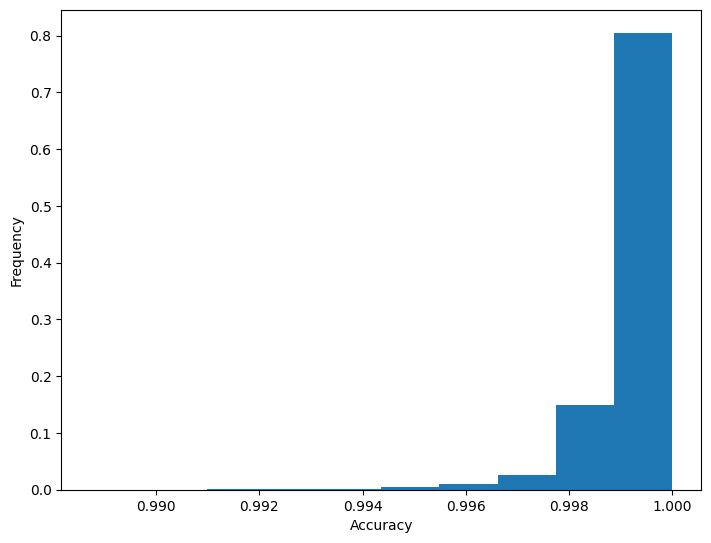

In [ ]:
# CONFIG SIMUL FUNCTION
config_simul = {
    "periods_per_epis": 10000,      # periods
    "simul_vol_scale": 1,

    "mc_draws": 256,               # only applies if shock is continuous
}

# CREATE SIMUL FUNCTION
def get_simul_fn(env, config):
  episode_simul_fn = create_episode_simul_fn(env, config)
  episode_loss_fn = create_episode_loss_fn(env, config)

  def simul_fn(train_state, simul_rng):
    """Get obs for simul and then calculate loss function"""
    simul_obs = episode_simul_fn(train_state, simul_rng)
    loss, simul_metrics = episode_loss_fn(train_state.params, train_state, simul_obs, simul_rng)
    return simul_obs, simul_metrics

  return simul_fn

# RUN SIMUL
rng_simul = random.PRNGKey(1)
env_simul = Model()
simul_fn = jax.jit(get_simul_fn(env_simul, config_simul))
simul_obs, simul_metrics = simul_fn(final_train_state, rng_simul)
print(simul_metrics)
# # GET STATISTICS
obs_quantiles = jnp.quantile(simul_obs, jnp.array([0.1,0.25,0.5,0.75,0.9]), axis=0)
acc_quantiles = jnp.quantile(simul_metrics[1], jnp.array([0.1,0.25,0.4, 0.75,0.9]))
print('Observations Quantiles (10%,25%,50%,75%,90%)', obs_quantiles)
print('Minimum Accuracy', jnp.min(simul_metrics[1]))
print('Accuracies Quantiles (10%,25%,50%,75%,90%)', acc_quantiles)

# HISTOGRAM OF ACCURACIES
counts, bins = jnp.histogram(simul_metrics[1])
freqs = counts/config_simul["periods_per_epis"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.hist(bins[:-1], bins, weights=freqs)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
# plt.show
fig.savefig(config['working_dir']+config['run_name']+'/acurracy_hists.jpg', bbox_inches="tight", pad_inches=1)


# Evaluate Accuracy of MC Estimation

{'error_1_draws': Array(0.00704697, dtype=float64), 'error_4_draws': Array(0.00326178, dtype=float64), 'error_16_draws': Array(0.00147381, dtype=float64), 'error_64_draws': Array(0.00092192, dtype=float64), 'error_256_draws': Array(0.00041204, dtype=float64)}
[0.007046967244546932, 0.0032617806807877393, 0.0014738100183919987, 0.0009219225304782928, 0.0004120413640682382]


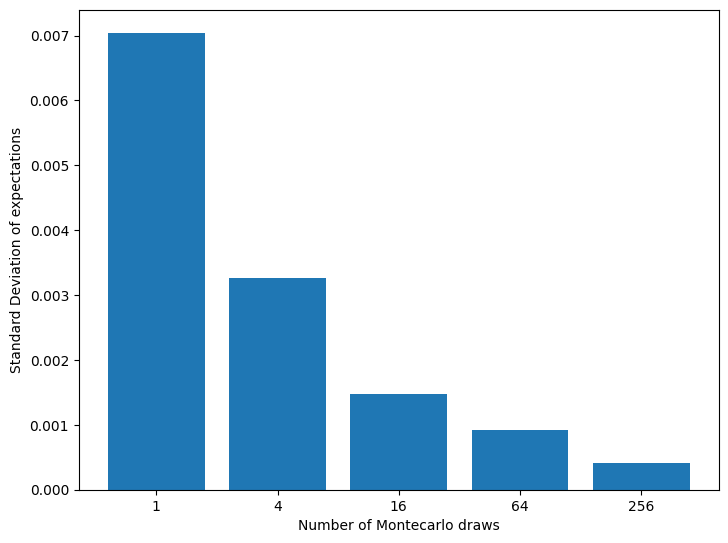

In [ ]:
# evaluate montecarlo estimation of expectation
env = Model()
rng_mc = random.PRNGKey(0)
params_test = final_train_state.params # Choose parameteres to test
nn_policy_test = final_train_state.apply_fn

def get_expectation_fn(nn_policy, params, env):
  def expectation(n_draws, rng,  obs):
    policy = nn_policy(params, obs)
    mc_obs = env.mc_shocks(rng, mc_draws=n_draws)
    mc_nextobs = jax.vmap(env.step, in_axes=(None, None,0))(obs, policy, mc_obs)
    mc_nextpols = nn_policy(params,jnp.stack(mc_nextobs))
    exp = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
    return exp
  return expectation

rng_mc, *mc_rngs = jax.random.split(rng_mc, 100 + 1)

# obs_list = list(obs_quantiles)
obs_list = [env.initial_obs(rng_mc)]
n_draws_list = [1,4,16,64,256]
# n_draws_list = [500, 1000]
rng_list =list(mc_rngs)

mc_explist = {n_draws_list[i]: [] for i in range(len(n_draws_list))}
mc_error = {f"error_{n_draws_list[i]}_draws": [] for i in range(len(n_draws_list))}
for i in range(len(n_draws_list)):
  for j in range(len(rng_list)):
    for k in range(len(obs_list)):
      # exp_jitted = jax.jit(get_expectation_fn(nn_forward, params, env)).lower(n_draws_list[i], rng_list[j], obs_list[k]).compile
      mc_explist[n_draws_list[i]].append(get_expectation_fn(nn_policy_test, params_test, env)(n_draws_list[i], rng_list[j],  obs_list[k]))
      # mc_eval[(i,j,k)] = exp_jitted(n_draws_list[i], rng_list[j],  obs_list[k])
  mc_error[f"error_{n_draws_list[i]}_draws"] = jnp.std(jnp.array(mc_explist[n_draws_list[i]]))
print(mc_error)

error_list = [float(mc_error[f"error_{n_draws_list[i]}_draws"]) for i in range(len(n_draws_list))]
print(error_list)
n_drawsstr_list = [str(n_draws_list[i]) for i in range(len(n_draws_list))]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_drawsstr_list, error_list)
plt.xlabel('Number of Montecarlo draws')
plt.ylabel('Standard Deviation of expectations')
# plt.show
fig.savefig(config['working_dir']+config['run_name']+'/mc_eval.jpg', bbox_inches="tight", pad_inches=1)


# Impulse Responses

shape of ir shocks: (2, 40, 1)


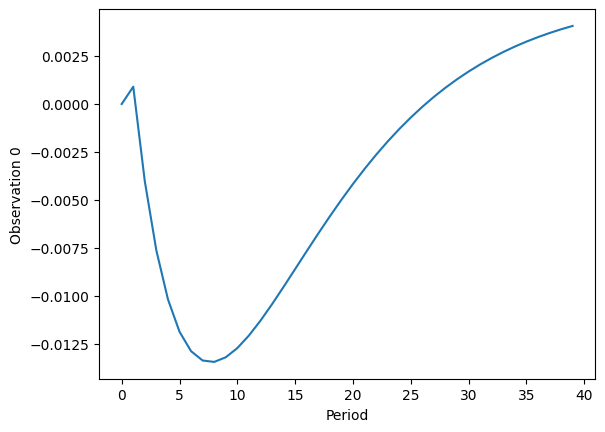

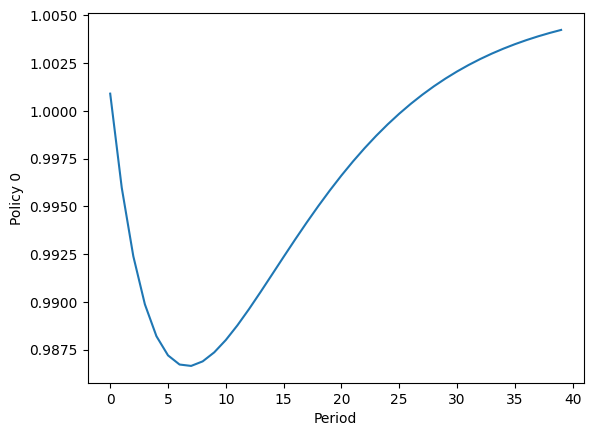

In [ ]:
# Impulse responses of dynare policy vs learned policy
env = Model()

ir_shocks = env.ir_shocks()
print("shape of ir shocks:", ir_shocks.shape)

def ir(env, train_state, shocks):
  def step(obs, shock):
    policy = train_state.apply_fn(train_state.params, obs)
    next_obs = env.step(obs, policy, shock)
    obs_pol_pair = (obs,policy)
    return next_obs, obs_pol_pair
  obs_init = jnp.zeros_like(env.obs_ss)
  final_obs, obs_pol_pairs = lax.scan(step, obs_init, shocks)
  return final_obs, obs_pol_pairs

ir_final_obs, ir_obs_pol_pairs = jax.vmap(ir, in_axes = (None,None,0))(env, final_train_state, ir_shocks)
ir_obs, ir_policy = ir_obs_pol_pairs

# PLOT
ir_index = 0 # choose the IR exercise
obs_index = 0 # choose the obs to plot
obs_label = f"Observation {obs_index}" # create label
policy_index = 0 # choose the policy to plot
policy_label = f"Policy {policy_index}" # create label
# plot obs
plt.plot(list(range(40)), ir_obs[ir_index,:,obs_index], label ="observation")
plt.savefig(config['working_dir']+config['run_name']+'/IRobs.jpg')
plt.xlabel("Period")
plt.ylabel(obs_label)
plt.show()
#plot policy
plt.plot(list(range(40)), ir_policy[0,:,policy_index], label ="policy")
plt.savefig(config['working_dir']+config['run_name']+'/IRpolicy.jpg')
plt.xlabel("Period")
plt.ylabel(policy_label)
plt.show()


# Test Results

We will first test that the environment works as its supposed to. First, we check if the error in the steady state is 0 under the loglinear policy. for that, we will firsr create a function that calculates the loss in the steady state

### Test 1: steady state

In [ ]:
# Test policies in steady state
env = Model()
params_test = final_train_state.params # Choose parameteres to test
nn_policy_test = final_train_state.apply_fn
rng_test = random.PRNGKey(1)

# test steady state policies
obs_init = env.initial_obs(rng_test)
obs_ss = jnp.zeros_like(obs_init, dtype=jnp.float32)
policy_ss = nn_policy_test(params_test, obs_ss) # nn_policy is the nn policy that comes from the training experiment
print("Pretrain Policy in ss (should be ~ 1):", policy_ss)

# check that steady state policies takes a zero step
shock_ss = jnp.array([0])
obs_next_ss = env.step(obs_ss, policy_ss, shock_ss)
print("Nex obs after ss policies (should be ~ 0):", obs_next_ss)
# print("Neural Net Gives 0 step in StSt?",jnp.allclose(obs_next_ss, obs_ss, rtol=1e-02))
print("Difference between next obs after applying nn_policy and stst", obs_next_ss-obs_ss)

# calculate expectation in StSt
start = time()
exp_ss = env.expect_realization(obs_ss, policy_ss)
print("Expectation in SS:", exp_ss)
finish = time()
print(f"executing an expectation realization took {(finish-start)*1000} miliseconds")

# calculate loss in STST
start = time()
mean_loss, mean_accuracy, min_accuracy = env.loss(obs_ss,exp_ss, policy_ss)
print("Mean Loss in SS:", mean_loss, "Mean accuracy in SS:", mean_accuracy, "Min. accuracy in SS:", min_accuracy)
finish = time()
print(f"executing the loss function {(finish-start)*1000} miliseconds")


Pretrain Policy in ss (should be ~ 1): [0.9985242]
Nex obs after ss policies (should be ~ 0): [-4.4345856e-05  0.0000000e+00]
Difference between next obs after applying nn_policy and stst [-4.4345856e-05  0.0000000e+00]
Expectation in SS: 0.56312555
executing an expectation realization took 41.3203239440918 miliseconds
Mean Loss in SS: 1.4210855e-14 Mean accuracy in SS: 0.9999999 Min. accuracy in SS: 0.9999999
executing the loss function 9.791135787963867 miliseconds


### Test 2: step and loss function

Now we test that the step function and loss function works correctly.

In [ ]:
env = Model()
rng_test = random.PRNGKey(0)
params_test = final_train_state.params # Choose parameteres to test
nn_policy_test = final_train_state.apply_fn
# test envreset
obs_init = env.initial_obs(rng_test)
print("shape of initial obs:", obs_init.shape)

# test step
shock = env.sample_shock(rng_test)
policy = nn_policy_test(params_test, obs_init)
obs_next = env.step(obs_init,policy,shock)
print("shape of next obs", obs_next.shape)

# test expectation
mc_shocks = env.mc_shocks(rng_test, config["mc_draws"])
mc_nextobs = jax.vmap(env.step, in_axes=(None, None,0))(obs_init, policy, mc_shocks)
mc_nextpols = nn_policy_test(params_test,jnp.stack(mc_nextobs))
exp = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
print("shape of exp", exp.shape)
print("exp", exp)

#test loss
mean_loss, mean_accuracy, min_accuracy  = env.loss(obs_init, exp, policy)
print("Mean Loss in init obs:", mean_loss, "Mean accuracy in init obs:", mean_accuracy, "Min. accuracy in init obs:", min_accuracy)



shape of initial obs: (2,)
shape of next obs (2,)
shape of exp ()
exp 0.53553444
Mean Loss in init obs: 1.0706799e-08 Mean accuracy in init obs: 0.9998965 Min. accuracy in init obs: 0.9998965


### Test 3: Simulating the environment (only states and policy, no loss)

In [ ]:
# Simulate env
env = Model()
params_test = final_train_state.params # Choose parameteres to test
nn_policy_test = final_train_state.apply_fn
rng_test = random.PRNGKey(1)
obs_init = env.initial_obs(rng_test)

def period_step_fn(obs, shock, nn_params):
  policy = nn_policy_test(nn_params, obs)
  obs_next = env.step(obs, policy, jnp.array([shock]))  # apply period steps for each row shock in shocks.
  return obs_next, (obs_next, policy)

n_periods = 1000000
shocks = env.sample_shock(rng_test, n_draws=n_periods)
period_step = jax.tree_util.Partial(period_step_fn, nn_params = params_test)
start = time()
obs_final, obs_policy_pair = lax.scan(period_step,obs_init,shocks)
finish = time()
print(f"Simulating {n_periods} with only state evolution given policy took {(finish-start)} seconds")

obs, policy = obs_policy_pair
print('mean for each state (should be ~ 0)')
print(jnp.mean(obs,axis=0))
print('std for each state (if normalized, should be ~ 1)')
print(jnp.std(obs, axis=0))
print('average policy', jnp.mean(policy,axis=0))

Simulating 1000000 with only state evolution given policy took 0.28539276123046875 seconds
mean for each state (should be ~ 0)
[1.8740162e-04 8.0411519e-05]
std for each state (if normalized, should be ~ 1)
[0.03095767 0.02291827]
average policy [1.0006654]


## Analysis

We now perform three analysis. First, we analyse business cycle frequencies and amplifications.

In [ ]:
""" Calculate fourier transform """

# simulate 100000 periods
rng_test = random.PRNGKey(0)
env = Model()
n_periods = 1000000
state_init = jnp.array(jnp.log(jax.random.uniform(rng_test,(2*env.n_sectors,),minval=0.9,maxval=1.1)))
shocks = jax.random.multivariate_normal(rng_test, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(n_periods,))
_, state_policy_pairs = lax.scan(env.step,state_init,shocks)
states, _ = state_policy_pairs
print(states.shape) #check that last dimension is the time dimension
fourier = jax.scipy.fft.dct(states)
del states
del shocks


TypeError: ignored

## Obsolete

In [ ]:
# def loss(self, rng, state, policy_params):

  #   # process state
  #   state = state*self.states_sd
  #   K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
  #   a = state[self.n_sectors:]+self.states_ss[self.n_sectors:]

  #   # calculate the policy variables
  #   policy = self.policy_fn(policy_params,state)
  #   I = policy[:self.n_sectors]
  #   Q = policy[self.n_sectors:2*self.n_sectors]
  #   P = policy[2*self.n_sectors:3*self.n_sectors]
  #   L = policy[3*self.n_sectors:]

  #   #Rest of variables
  #   A = jnp.exp(a)
  #   Lagg = jnp.sum(L)  # Aggregate labor
  #   Pagg = jnp.dot(jnp.transpose(self.xi),P**(1-self.sigma_c))**(1/(1-self.sigma_c)) # Agg price
  #   Cagg = 1/Pagg  # Agg consumption
  #   C = self.xi * (P/Pagg)**(-self.sigma_c) * Cagg  # Sectoral Consumption
  #   Pm = (jnp.dot(jnp.transpose(self.Gamma_M),P**(1-self.sigma_m)))**(1/(1-self.sigma_m)) #  Interm. Price Index
  #   M = self.mu * (Pm/P)**(-self.sigma_q) * Q  # Sectoral Intermediates
  #   Mout = P**(-self.sigma_m) * jnp.dot(self.Gamma_M,Pm**(self.sigma_m)*M) # interm sold by sector
  #   Pk = (jnp.dot(jnp.transpose(self.Gamma_I),P**(1-self.sigma_I)))**(1/(1-self.sigma_I)) #  Capital Price Index
  #   Iout = P**(-self.sigma_I) * jnp.dot(self.Gamma_I,Pk**(self.sigma_I)*I) # New Capital sold by sector
  #   Y = (A * (
  #       self.alpha**(1/self.sigma_y)*K**((self.sigma_y-1)/self.sigma_y) +
  #       (1-self.alpha)**(1/self.sigma_y)*L**((self.sigma_y-1)/self.sigma_y)
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #   # Now we calculate the expectation term through montecarlo. We know K_next
  #   K_next = (1-self.delta)*K + I  # get next K

  #   # First, we get what is inside expectations for the realization of one shock
  #   def exp_realization(shock):
  #     # get next state
  #     a_next = self.rho*a + shock
  #     state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss

  #     #calculate policies
  #     policy_next = self.policy_fn(policy_params,state_next)
  #     I_next = policy_next[:self.n_sectors]
  #     Q_next = policy_next[self.n_sectors:2*self.n_sectors]
  #     P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
  #     L_next = policy_next[3*self.n_sectors:]

  #     # Solve for the rest of the endogenous variables
  #     A_next = jnp.exp(a_next)
  #     Lagg = jnp.sum(L)
  #     Pk_next = (jnp.dot(jnp.transpose(self.Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
  #     Y_next = (A_next * (
  #       self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) +
  #       (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y)
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #     # Solve for the expectation term
  #     exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
  #       ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
  #       (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
  #       (1-self.delta)*Pk_next)
  #     return exp_realization

  #   # Now we calculate the expectation through montecarlo
  #   def monte_carlo_exp(rng, mc_draws):
  #     shocks = jax.random.multivariate_normal(rng, jnp.zeros((self.n_sectors,)), self.Sigma_A, shape=(mc_draws,))
  #     exp = jnp.mean(jax.vmap(exp_realization)(shocks),axis=0)
  #     return exp
  #   # exp = monte_carlo_exp(rng, self.mc_draws)
  #   # rng, *mc_rngs  = random.split(rng,self.n_mcs+1)
  #   exp = monte_carlo_exp(rng,self.mc_draws)

  #   # Calculate model implied Q
  #   Qmod = ((
  #       (1-self.mu)**(1/self.sigma_q)*Y**((self.sigma_q-1)/self.sigma_q) +
  #       (self.mu)**(1/self.sigma_q)*M**((self.sigma_q-1)/self.sigma_q)
  #       )**(self.sigma_q/(self.sigma_q-1)))

  #   # Calculate right hand side of error eq for L
  #   Lmod = (P*A**((self.sigma_y-1)/self.sigma_y) *
  #     ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
  #     ((1-self.alpha)*Y/L)**(1/self.sigma_y))

  #   Q_loss = Q / Qmod - 1
  #   Pk_loss = Pk/(self.beta*exp) - 1
  #   Market_loss = Q / (C+Mout+Iout) - 1
  #   L_loss = Lagg**(1/self.eps_l)/Lmod - 1
  #   loss = (jnp.sum(jnp.array([jnp.square(Q_loss),jnp.square(Pk_loss),jnp.square(Market_loss), jnp.square(L_loss)])))/self.n_actions

  #   return lax.stop_gradient(loss)

  # def expectation(self, rng, state, K_next, policy_params):
  #   K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
  #   a = state[self.n_sectors:]

  #   def exp_realization(shock):
  #     # get next state
  #     a_next = self.rho*a + shock
  #     state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss

  #     #calculate policies
  #     policy_next = self.policy_fn(policy_params,state_next)
  #     I_next = policy_next[:self.n_sectors]
  #     Q_next = policy_next[self.n_sectors:2*self.n_sectors]
  #     P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
  #     L_next = policy_next[3*self.n_sectors:]

  #     # Solve for the rest of the endogenous variables
  #     A_next = jnp.exp(a_next)
  #     Lagg = jnp.sum(L)
  #     Pk_next = (jnp.dot(jnp.transpose(self.Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
  #     Y_next = (A_next * (
  #       self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) +
  #       (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y)
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #     # Solve for the expectation term
  #     exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
  #       ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
  #       (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
  #       (1-self.delta)*Pk_next)
  #     return exp_realization

  #   shocks = jax.random.multivariate_normal(rng, jnp.zeros((self.n_sectors,)), self.Sigma_A, shape=(self.mc_draws,))
  #   exp = jnp.mean(jax.vmap(exp_realization)(shocks), axis=0)
  #   return exp

In [ ]:
# Environment
# class ProdNetRbc_SS():
#   """A JAX implementation of an RBC model with Production Networks."""

#   def __init__(self, params = params, states_ss=states_ss, policies_ss=policies_ss, states_sd = states_sd, policy_layers=[1024,1024]):

#     self.alpha = params["alpha"]
#     self.beta = params["beta"]
#     self.delta = params["delta"]
#     self.rho = params["rho"]
#     self.eps_l = params["eps_l"]
#     self.sigma_c = params["sigma_c"]
#     self.sigma_m = params["sigma_m"]
#     self.sigma_q = params["sigma_q"]
#     self.sigma_y = params["sigma_y"]
#     self.sigma_I = params["sigma_I"]
#     self.xi = jnp.array(params["xi"])
#     self.mu = jnp.array(params["mu"])
#     self.Gamma_M = jnp.array(params["Gamma_M"])
#     self.Gamma_I = jnp.array(params["Gamma_I"])
#     self.n_sectors = params["n_sectors"]
#     self.states_ss = jnp.concatenate([states_ss,jnp.zeros(shape=(self.n_sectors,))])
#     self.policies_ss = jnp.array(policies_ss)
#     self.n_actions = 4*self.n_sectors
#     self.states_sd = states_sd
#   def initial_state(self):
#     state_init = jnp.zeros(shape=(2*self.n_sectors,))
#     return lax.stop_gradient(state_init)

#   def step(self, state):
#     state = state*self.states_sd
#     K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
#     a = state[self.n_sectors:]
#     policy = jnp.exp(self.policies_ss)
#     K_next = (1-self.delta)*K + policy[:self.n_sectors]
#     a_next = self.rho*a
#     state_next = (jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss)/self.states_sd
#     # return lax.stop_gradient(state_next), lax.stop_gradient(state_next)
#     return lax.stop_gradient(state_next)


#   def loss(self, state):
#     state = state*self.states_sd
#     # process state
#     K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])

#     # calculate the policy variables
#     policy = jnp.exp(self.policies_ss)
#     I = policy[:self.n_sectors]
#     Q = policy[self.n_sectors:2*self.n_sectors]
#     P = policy[2*self.n_sectors:3*self.n_sectors]
#     L = policy[3*self.n_sectors:]

#     #Rest of variables
#     Lagg = jnp.sum(L)  # Aggregate labor
#     Pagg = jnp.dot(jnp.transpose(self.xi),P**(1-self.sigma_c))**(1/(1-self.sigma_c)) # Agg price
#     Cagg = 1/Pagg  # Agg consumption
#     C = self.xi * (P/Pagg)**(-self.sigma_c) * Cagg  # Sectoral Consumption
#     Pm = (jnp.dot(jnp.transpose(self.Gamma_M),P**(1-self.sigma_m)))**(1/(1-self.sigma_m)) #  Interm. Price Index
#     M = self.mu * (Pm/P)**(-self.sigma_q) * Q  # Sectoral Intermediates
#     Mout = P**(-self.sigma_m) * jnp.dot(self.Gamma_M,Pm**(self.sigma_m)*M) # interm sold by sector
#     Pk = (jnp.dot(jnp.transpose(self.Gamma_I),P**(1-self.sigma_I)))**(1/(1-self.sigma_I)) #  Capital Price Index
#     Iout = P**(-self.sigma_I) * jnp.dot(self.Gamma_I,Pk**(self.sigma_I)*I) # New Capital sold by sector
#     Y = (
#         (
#         self.alpha**(1/self.sigma_y)*K**((self.sigma_y-1)/self.sigma_y) +
#         (1-self.alpha)**(1/self.sigma_y)*L**((self.sigma_y-1)/self.sigma_y)
#         )**(self.sigma_y/(self.sigma_y-1)))

#     print(Y)
#     # Now we calculate the expectation term through montecarlo. We know K_next
#     K_next = (1-self.delta)*K + I  # get next K
#     exp = (
#         P *
#         ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
#         (self.alpha*Y/K_next)**(1/self.sigma_y) +
#         (1-self.delta)*Pk
#         )
#     # Now we get what is inside expectations for each realization of the shock
#     # def exp_realization():
#     #   # a_next = self.rho*a
#     #   # state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss

#     #   #calculate policies
#     #   # policy_next = policy
#     #   # I_next = policy_next[:self.n_sectors]
#     #   # Q_next = policy_next[self.n_sectors:2*self.n_sectors]
#     #   # P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
#     #   # L_next = policy_next[3*self.n_sectors:]

#     #   # Solve for the rest of the endogenous variables
#     #   # A_next = jnp.exp(a_next)
#     #   # Lagg = jnp.sum(L)
#     #   # Pk_next = (jnp.dot(jnp.transpose(Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
#     #   # Y_next = (A_next * (
#     #   #   self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) +
#     #   #   (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y)
#     #   #   )**(self.sigma_y/(self.sigma_y-1)))

#     #   # Solve for the expectation term
#     #   # exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
#     #   #   ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
#     #   #   (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
#     #   #   (1-self.delta)*Pk_next)
#     #   exp_realization = (P*A**((self.sigma_y-1)/self.sigma_y) *
#     #     ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
#     #     (self.alpha*Y/K_next)**(1/self.sigma_y) +
#     #     (1-self.delta)*Pk)
#     #   return exp_realization

#     # Now we calculate the expectation

#     # Calculate model implied Q
#     Qmod = ((
#         (1-self.mu)**(1/self.sigma_q)*Y**((self.sigma_q-1)/self.sigma_q) +
#         (self.mu)**(1/self.sigma_q)*M**((self.sigma_q-1)/self.sigma_q)
#         )**(self.sigma_q/(self.sigma_q-1)))

#     # Calculate right hand side of error eq for L
#     Lmod = (P *
#       ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
#       ((1-self.alpha)*Y/L)**(1/self.sigma_y))

#     Q_loss = Q / Qmod - 1
#     Pk_loss = Pk/(self.beta*exp) - 1
#     Market_loss = Q / (C+Mout+Iout) - 1
#     L_loss = Lagg**(1/self.eps_l)/Lmod - 1
#     loss = (jnp.sum(jnp.array([jnp.square(Q_loss),jnp.square(Pk_loss),jnp.square(Market_loss), jnp.square(L_loss)])))/self.n_actions

#     return lax.stop_gradient(loss)

In [ ]:
def run_experiment(env, config):
  """Runs experiment."""
  cores_count = len(jax.devices())  # get available TPU cores.
  nn_policy = NeuralNet(config["layers"] + [env.n_actions])
  optim = optax.adam(config["learning_rate"])  # define optimiser.

  rng, rng_e = random.split(random.PRNGKey(config["seed"]), 2)  # prng keys.
  dummy_obs = env.initial_obs(rng_e)  # dummy for net init.
  params = params # initialise params.
  nn_forward = nn_policy.apply
  mean_loss = jnp.array([0.0]) # initialize loss
  # mean_abs_loss = jnp.array([0.0]) # initialize loss
  opt_state = optim.init(params)  # initialise optimiser stats.
  learn = jax.jit(get_epoch_learner_fn(env, nn_forward, optim.update, config["batch_size"], config["epoch_iters"]))
  # learn = jax.pmap(learn, axis_name='i')  # replicate over multiple cores.

  #  broadcast = lambda x: jnp.broadcast_to(x, (cores_count, config["n_batches"]) + x.shape)
  # params = jax.tree_map(broadcast, params)  # broadcast to cores and batch.
  # opt_state = jax.tree_map(broadcast, opt_state)  # broadcast to cores and batch
  # mean_loss = jax.tree_map(broadcast, mean_loss)
  # mean_abs_loss = jax.tree_map(broadcast, mean_abs_loss)

  # rng, *env_rngs = jax.random.split(rng, cores_count * config["n_batches"]+ 1)
  # env_obs = jax.vmap(env.initial_obs)(jnp.stack(env_rngs))  # init envs.
  # rng, *step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  # rng, *eval_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  rng, env_rngs = jax.random.split(rng, cores_count * config["n_batches"]+ 1)
  env_obs = env.initial_obs(env_rngs)  # init envs.
  rng, step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  rng, eval_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)

  # reshape = lambda x: x.reshape((cores_count, config["n_batches"]) + x.shape[1:])
  # step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
  # eval_rngs = reshape(jnp.stack(eval_rngs))  # add dimension to pmap over.
  # env_obs = reshape(env_obs)  # add dimension to pmap over.

  mean_losses = []
  mean_accuracy = []
  num_steps = cores_count * config["epoch_iters"] * config["batch_size"] * config["n_batches"]

  with TimeIt(tag='COMPILATION'):
    learn(params, opt_state, step_rngs, env_obs, mean_loss)  # compiles

  #First run, we calculate periods per second
  with TimeIt(tag='EXECUTION', steps=num_steps):
    params, opt_state, step_rngs, env_obs, mean_loss = learn(
        params, opt_state, step_rngs, env_obs, mean_loss)

  #Rest of the runs
  for i in range(2,config["n_epochs"]+1):
    rng, step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
    # step_rngs = reshape(jnp.stack(step_rngs))
    params, opt_state, step_rngs, env_obs, mean_loss = learn(
        params, opt_state, step_rngs, env_obs, mean_loss)

    mean_losses.append(jnp.mean(mean_loss))
    # mean_accuracy.append((1- jnp.mean(mean_abs_loss))*100)

    print('Iteration:', i*config["epoch_iters"],
          ", Mean_loss:", jnp.mean(mean_loss),
          ", Learning rate:", config["learning_rate"](i*config["epoch_iters"]),
          # ", Mean accuracy (%):", (1- jnp.mean(mean_abs_loss))*100
          )

    if i%config["reset_env_nepochs"]==0:
      env_obs = jnp.zeros_like(env_obs)
      print("ENV RESET")

  # Print best result
  # print("Maximum accuracy attained in training:", max(mean_accuracy))

  #Checkpoint
  checkpoints.save_checkpoint(ckpt_dir=config['working_dir']+config['run_name'], target=params, step=config["n_epochs"]*config["epoch_iters"])

  # Plots
  plt.plot([i for i in range(len(mean_losses[100:]))], mean_losses[100:])
  plt.xlabel('Steps')
  plt.ylabel('Mean Losses')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_losses.jpg')
  plt.close()


  return params, optim, nn_policy, mean_losses, mean_accuracy

In [ ]:
def get_epoch_learner_fn(
    env, nn_forward, opt_update, batch_size, epoch_iters):
  """It runs and epoch with learing. This is what the compiler reads and parallelize (the minimal unit of computation)."""

  def period_loss_fn(nn_params, loss_rng, env_obs):

    # get rngs
    loss_rng, mc_rng = random.split(loss_rng,2)

    # Step the environemnt
    period_shock = jax.random.multivariate_normal(loss_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A/100)
    policy = nn_forward(nn_params, env_obs)
    obs_final = env.step(env_obs, policy, period_shock)  # apply period steps for each row shock in shocks.

    # calculate exp
    mc_shocks = jax.random.multivariate_normal(mc_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(200000,))
    mc_nextobs = jax.vmap(env.step, in_axes=(None, None, 0))(env_obs, policy, mc_shocks)
    del mc_shocks
    mc_nextpols = nn_forward(nn_params,jnp.stack(mc_nextobs))
    exp = jnp.mean(jax.vmap(env.exp_realization)(mc_nextobs, mc_nextpols))

    loss = env.loss(env_obs, exp, policy)

    return loss, (obs_final, jnp.array([loss]))

  def update_fn(nn_params, opt_state, rng, env_obs, mean_loss):
    """Compute a gradient update from a single trajectory."""
    rng, loss_rng = random.split(rng,2)
    grads, aux_info  = jax.grad(  # compute gradient on a single trajectory.
        period_loss_fn, has_aux=True)(nn_params, loss_rng, env_obs)
    new_env_obs, mean_loss = aux_info
    # grads = lax.pmean(grads, axis_name='j')  # reduce mean (average grads) across cores.
    # grads = lax.pmean(grads, axis_name='i')  # reduce mean (average grads) across batch.
    updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
    new_params = optax.apply_updates(nn_params, updates)  # update parameters.
    return new_params, new_opt_state, rng, new_env_obs, mean_loss

  # def learner_fn(params, opt_state, rngs, env_obs, mean_loss):
  #   """Vectorise and repeat the update."""
  #   batched_update_fn = jax.vmap(update_fn, axis_name='j')  # vectorize across batch.
  #   def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
  #     params, opt_state, rngs, env_obs, mean_loss = val
  #     return batched_update_fn(params, opt_state, rngs, env_obs, mean_loss)
  #   return lax.fori_loop(0, epoch_iters, iterate_fn, (
  #       params, opt_state, rngs, env_obs, mean_loss))

  return update_fn

In [ ]:
def get_epoch_update_fn(env, config):
  """It runs and epoch with learning. This is what the compiler reads and parallelize."""

  def sample_epis_obs(train_state, epis_rng):
    "sample obs of an episode"
    env_obs = env.initial_obs(epis_rng)
    epis_rng, *period_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    def period_step(env_obs, period_rng):
      policy = train_state.apply_fn(train_state.params, env_obs)                 # calculate policy
      period_shock = env.sample_shock(period_rng)         # Sample next obs
      obs_next = env.step(env_obs, policy, period_shock)  # apply period steps.
      return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop
    _, epis_obs = lax.scan(period_step, env_obs, jnp.stack(period_rngs)) # we get the obs_batch
    return epis_obs

  def epis_loss_fn(params, nn_policy, epis_rng, obs_batch):
    """Loss function of an episode, which has periods_per_epis time periods."""
    epis_rng, *period_mc_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    policies_batch = nn_policy(params, obs_batch) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """Loss function for an individual period."""
      mc_shocks = env.mc_shocks(period_mc_rng, config["mc_draws"])
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = nn_policy(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      mean_loss, mean_accuracy, min_accuracy = env.loss(obs, expect, policy) # calculate loss
      return mean_loss, mean_accuracy, min_accuracy

    # parallelize callculation of period_loss for the entire batch
    mean_losses, mean_accuracies, min_accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
    mean_loss = jnp.mean(mean_losses)                   # average accross periods
    mean_accuracy = jnp.mean(mean_accuracies)           # average accross periods
    min_accuracy = jnp.min(min_accuracies)              # min accross periods and across eqs within period
    metrics = jnp.array([mean_loss, mean_accuracy, min_accuracy]) # pass as auxiliary info
    return mean_loss, metrics

  def epis_update_fn(train_state, epis_rng):
    """Compute a gradient update from a single episode."""
    epis_obs = sample_epis_obs(train_state, epis_rng)
    grads, epis_metrics  = jax.grad(  # compute gradient on a single trajectory.
        epis_loss_fn, has_aux=True)(train_state.params, train_state.apply_fn, epis_rng, epis_obs)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, epis_metrics

  # def batch_update_fn(train_state, batch_rng):
  #   """Compute a gradient update from a single episode."""
  #   batch_rng, *epis_rng = random.split(batch_rng, config["epis_per_step"]+1)
  #   batch_obs = jax.vmap(sample_epis_obs, in_axes = (None,0))(train_state, jnp.stack(epis_rng))
  #   grads, epis_metrics  = jax.grad(  # compute gradient on a single trajectory.
  #       epis_loss_fn, has_aux=True)(train_state.params, train_state.apply_fn, epis_rng, batch_obs)
  #   train_state = train_state.apply_gradients(grads=grads)
  #   return train_state, epis_metrics

  def epoch_update_fn(train_state, epoch_rng):
    """Vectorise and repeat the update to complete an epoch, made aout of steps_per_epoch episodes."""
    epoch_rng, *epis_rngs = random.split(epoch_rng, config["steps_per_epoch"]+1)
    train_state, epoch_metrics = lax.scan(epis_update_fn, train_state, jnp.stack(epis_rngs))
    return train_state, epoch_rng, epoch_metrics

  return epoch_update_fn

Create Training function
No we define a function specifying an entire epoch of learning. This is the minimal unti lfo computation that we wil compile and pass to all the devices (devices are sunchronized to average gradients).

In [ ]:
def get_epoch_update_fn(env, config):
  """It runs and epoch with learning. This is what the compiler reads and parallelize."""

  def sample_epis_obs(train_state, epis_rng):
    "sample obs of an episode"
    env_obs = env.initial_obs(epis_rng)
    epis_rng, *period_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    def period_step(env_obs, period_rng):
      policy = train_state.apply_fn(train_state.params, env_obs)                 # calculate policy
      period_shock = config["simul_vol_scale"]*env.sample_shock(period_rng)         # Sample next obs
      obs_next = env.step(env_obs, policy, period_shock)  # apply period steps.
      return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop
    _, epis_obs = lax.scan(period_step, env_obs, jnp.stack(period_rngs)) # we get the obs_batch
    return epis_obs

  def epis_loss_fn(params, nn_policy, epis_rng, obs_batch):
    """Loss function of an episode, which has periods_per_epis time periods."""
    epis_rng, *period_mc_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    policies_batch = nn_policy(params, obs_batch) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """Loss function for an individual period."""
      mc_shocks = env.mc_shocks(period_mc_rng, config["mc_draws"])
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = nn_policy(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      mean_loss, mean_accuracy, min_accuracy = env.loss(obs, expect, policy) # calculate loss
      return mean_loss, mean_accuracy, min_accuracy

    # parallelize callculation of period_loss for the entire batch
    mean_losses, mean_accuracies, min_accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
    mean_loss = jnp.mean(mean_losses)                   # average accross periods
    mean_accuracy = jnp.mean(mean_accuracies)           # average accross periods
    min_accuracy = jnp.min(min_accuracies)              # min accross periods and across eqs within period
    metrics = jnp.array([mean_loss, mean_accuracy, min_accuracy]) # pass as auxiliary info
    return mean_loss, metrics

  def step_loss_fn(params, nn_policy, epis_rng, step_obs):
    mean_losses, step_metrics = jax.vmap(epis_loss_fn,in_axes = (None,None,0,0))(
        params, nn_policy, jnp.stack(epis_rng), step_obs)
    mean_loss = jnp.mean(mean_losses)
    step_metrics = jnp.mean(step_metrics,axis=0)
    return mean_loss, step_metrics

  def step_update_fn(train_state, step_rng):
    """Compute a gradient update from a single episode."""
    step_rng, *epis_rng = random.split(step_rng, config["epis_per_step"]+1)
    step_obs = jax.vmap(sample_epis_obs, in_axes = (None,0))(train_state, jnp.stack(epis_rng))
    grads, step_metrics  = jax.grad(step_loss_fn, has_aux=True)(
        train_state.params, train_state.apply_fn, epis_rng, step_obs)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, step_metrics

  def epoch_update_fn(train_state, epoch_rng):
    """Vectorise and repeat the update to complete an epoch, made aout of steps_per_epoch episodes."""
    epoch_rng, *step_rngs = random.split(epoch_rng, config["steps_per_epoch"]+1)
    train_state, epoch_metrics = lax.scan(step_update_fn, train_state, jnp.stack(step_rngs))
    return train_state, epoch_rng, epoch_metrics

  return epoch_update_fn